In [169]:
import pandas as pd
import numpy as np
import os

In [170]:
fileLoc = './all-crypto-currencies/crypto-markets.csv'
data = pd.read_csv(fileLoc)
data = data.dropna()

In [171]:
#most recent data for all the coins
coins_last = data.loc[data['date'] == '2018-03-10']

In [172]:
coins_last = coins_last.reset_index(drop='true')

# Calculating optimal clustering value

In [173]:
# (c) 2014 Reid Johnson
#
# Modified from:
# (c) 2013 Mikael Vejdemo-Johansson
# BSD License
#
# SciPy function to compute the gap statistic for evaluating k-means clustering.
#
# The gap statistic is defined by Tibshirani, Walther, Hastie in:
#  Estimating the number of clusters in a data set via the gap statistic
#  J. R. Statist. Soc. B (2001) 63, Part 2, pp 411-423

import scipy as sp
import scipy as sp
import scipy.cluster.vq
import scipy.spatial.distance
import scipy.stats
import sklearn.cluster

import pylab as pl

dst = sp.spatial.distance.euclidean

def gap_statistics(data, refs=None, nrefs=20, ks=range(1,11)):
    """Computes the gap statistics for an nxm dataset.

    The gap statistic measures the difference between within-cluster dispersion on an input
    dataset and that expected under an appropriate reference null distribution.

    Computation of the gap statistic, then, requires a series of reference (null) distributions.
    One may either input a precomputed set of reference distributions (via the parameter refs)
    or specify the number of reference distributions (via the parameter nrefs) for automatic 
    generation of uniform distributions within the bounding box of the dataset (data).

    Each computation of the gap statistic requires the clustering of the input dataset and of
    several reference distributions. To identify the optimal number of clusters k, the gap 
    statistic is computed over a range of possible values of k (via the parameter ks).

    For each value of k, within-cluster dispersion is calculated for the input dataset and each
    reference distribution. The calculation of the within-cluster dispersion for the reference
    distributions will have a degree of variation, which we measure by standard deviation or
    standard error.

    The estimated optimal number of clusters, then, is defined as the smallest value k such that
    gap_k is greater than or equal to the sum of gap_k+1 minus the expected error err_k+1.

    Args:
      data ((n,m) SciPy array): The dataset on which to compute the gap statistics.
      refs ((n,m,k) SciPy array, optional): A precomputed set of reference distributions. 
        Defaults to None.
      nrefs (int, optional): The number of reference distributions for automatic generation. 
        Defaults to 20.
      ks (list, optional): The list of values k for which to compute the gap statistics. 
        Defaults to range(1,11), which creates a list of values from 1 to 10.

    Returns:
      gaps: an array of gap statistics computed for each k.
      errs: an array of standard errors (se), with one corresponding to each gap computation.
      difs: an array of differences between each gap_k and the sum of gap_k+1 minus err_k+1.

    """
    shape = data.shape

    if refs==None:
        tops = data.max(axis=0) # maxima along the first axis (rows)
        bots = data.min(axis=0) # minima along the first axis (rows)
        dists = sp.matrix(sp.diag(tops-bots)) # the bounding box of the input dataset

        # Generate nrefs uniform distributions each in the half-open interval [0.0, 1.0)
        rands = sp.random.random_sample(size=(shape[0],shape[1], nrefs))

        # Adjust each of the uniform distributions to the bounding box of the input dataset
        for i in range(nrefs):
            rands[:,:,i] = rands[:,:,i]*dists+bots
    else:
        rands = refs

    gaps = sp.zeros((len(ks),))   # array for gap statistics (lenth ks)
    errs = sp.zeros((len(ks),))   # array for model standard errors (length ks)
    difs = sp.zeros((len(ks)-1,)) # array for differences between gaps (length ks-1)

    for (i,k) in enumerate(ks): # iterate over the range of k values
        # Cluster the input dataset via k-means clustering using the current value of k
        try:
            (kmc,kml) = sp.cluster.vq.kmeans2(data, k)
        except LinAlgError:
            kmeans = sklearn.cluster.KMeans(n_clusters=k).fit(data)
            (kmc, kml) = kmeans.cluster_centers_, kmeans.labels_

        # Generate within-dispersion measure for the clustering of the input dataset
        disp = sum([dst(data[m,:],kmc[kml[m],:]) for m in range(shape[0])])

        # Generate within-dispersion measures for the clusterings of the reference datasets
        refdisps = sp.zeros((rands.shape[2],))
        for j in range(rands.shape[2]):
            # Cluster the reference dataset via k-means clustering using the current value of k
            try:
                (kmc,kml) = sp.cluster.vq.kmeans2(rands[:,:,j], k)
            except LinAlgError:
                kmeans = sklearn.cluster.KMeans(n_clusters=k).fit(rands[:,:,j])
                (kmc, kml) = kmeans.cluster_centers_, kmeans.labels_

            refdisps[j] = sum([dst(rands[m,:,j],kmc[kml[m],:]) for m in range(shape[0])])

        # Compute the (estimated) gap statistic for k
        gaps[i] = sp.mean(sp.log(refdisps) - sp.log(disp))

        # Compute the expected error for k
        errs[i] = sp.sqrt(sum(((sp.log(refdisp)-sp.mean(sp.log(refdisps)))**2) \
                              for refdisp in refdisps)/float(nrefs)) * sp.sqrt(1+1/nrefs)

    # Compute the difference between gap_k and the sum of gap_k+1 minus err_k+1
    difs = sp.array([gaps[k] - (gaps[k+1]-errs[k+1]) for k in range(len(gaps)-1)])

    #print "Gaps: " + str(gaps)
    #print "Errs: " + str(errs)
    #print "Difs: " + str(difs)

    return gaps, errs, difs

def plot_gap_statistics(gaps, errs, difs):
    """Generates and shows plots for the gap statistics.

    A figure with two subplots is generated. The first subplot is an errorbar plot of the 
    estimated gap statistics computed for each value of k. The second subplot is a barplot 
    of the differences in the computed gap statistics.

    Args:
      gaps (SciPy array): An array of gap statistics, one computed for each k.
      errs (SciPy array): An array of standard errors (se), with one corresponding to each gap 
        computation.
      difs (SciPy array): An array of differences between each gap_k and the sum of gap_k+1 
        minus err_k+1.

    """
    # Create a figure
    fig = pl.figure(figsize=(16, 4))

    pl.subplots_adjust(wspace=0.35) # adjust the distance between figures

    # Subplot 1
    ax = fig.add_subplot(121)
    ind = range(1,len(gaps)+1) # the x values for the gaps

    # Create an errorbar plot
    rects = ax.errorbar(ind, gaps, yerr=errs, xerr=None, linewidth=1.0)

    # Add figure labels and ticks
    ax.set_title('Clustering Gap Statistics', fontsize=16)
    ax.set_xlabel('Number of clusters k', fontsize=14)
    ax.set_ylabel('Gap Statistic', fontsize=14)
    ax.set_xticks(ind)

    # Add figure bounds
    ax.set_ylim(0, max(gaps+errs)*1.1)
    ax.set_xlim(0, len(gaps)+1.0)

    # Subplot 2
    ax = fig.add_subplot(122)
    ind = range(1,len(difs)+1) # the x values for the difs
    
    max_gap = None
    if len(np.where(difs > 0)[0]) > 0:
        max_gap = np.where(difs > 0)[0][0] + 1 # the k with the first positive dif

    # Create a bar plot
    ax.bar(ind, difs, alpha=0.5, color='g', align='center')

    # Add figure labels and ticks
    if max_gap:
        ax.set_title('Clustering Gap Differences\n(k=%d Estimated as Optimal)' % (max_gap), \
                     fontsize=16)
    else:
        ax.set_title('Clustering Gap Differences\n', fontsize=16)
    ax.set_xlabel('Number of clusters k', fontsize=14)
    ax.set_ylabel('Gap Difference', fontsize=14)
    ax.xaxis.set_ticks(range(1,len(difs)+1))

    # Add figure bounds
    ax.set_ylim(min(difs)*1.2, max(difs)*1.2)
    ax.set_xlim(0, len(difs)+1.0)

    # Show the figure
    pl.show()

# (c) 2014 Reid Johnson
# BSD License
#
# Function to compute the sum of squared distance (SSQ) for evaluating k-means clustering.

import numpy as np
import scipy as sp
import sklearn.cluster
from scipy.spatial.distance import cdist, pdist

import pylab as pl

def ssq_statistics(data, ks=range(1,11), ssq_norm=True):
    """Computes the sum of squares for an nxm dataset.

    The sum of squares (SSQ) is a measure of within-cluster variation that measures the sum of 
    squared distances from cluster prototypes.

    Each computation of the SSQ requires the clustering of the input dataset. To identify the 
    optimal number of clusters k, the SSQ is computed over a range of possible values of k 
    (via the parameter ks). For each value of k, within-cluster dispersion is calculated for the 
    input dataset.

    The estimated optimal number of clusters, then, is defined as the value of k prior to an
    "elbow" point in the plot of SSQ values.

    Args:
      data ((n,m) SciPy array): The dataset on which to compute the gap statistics.
      ks (list, optional): The list of values k for which to compute the gap statistics. 
        Defaults to range(1,11), which creates a list of values from 1 to 10.

    Returns:
      ssqs: an array of SSQs, one computed for each k.

    """
    ssqs = sp.zeros((len(ks),)) # array for SSQs (lenth ks)

    #n_samples, n_features = data.shape # the number of rows (samples) and columns (features)
    #if n_samples >= 2500:
    #    # Generate a small sub-sample of the data
    #    data_sample = shuffle(data, random_state=0)[:1000]
    #else:
    #    data_sample = data

    for (i,k) in enumerate(ks): # iterate over the range of k values        
        # Fit the model on the data
        kmeans = sklearn.cluster.KMeans(n_clusters=k, random_state=0).fit(data)

        # Predict on the data (k-means) and get labels
        #labels = kmeans.predict(data)

        if ssq_norm:
            dist = np.min(cdist(data, kmeans.cluster_centers_, 'euclidean'), axis=1)

            tot_withinss = sum(dist**2) # Total within-cluster sum of squares
            totss = sum(pdist(data)**2) / data.shape[0] # The total sum of squares
            betweenss = totss - tot_withinss # The between-cluster sum of squares
            ssqs[i] = betweenss/totss*100
        else:
            # The sum of squared error (SSQ) for k
            ssqs[i] = kmeans.inertia_

    return ssqs

def plot_ssq_statistics(ssqs):
    """Generates and shows plots for the sum of squares (SSQ).

    A figure with one plot is generated. The plot is a bar plot of the SSQ computed for each 
    value of k.

    Args:
      ssqs (SciPy array): An array of SSQs, one computed for each k.

    """
    # Create a figure
    fig = pl.figure(figsize=(20, 13))

    ind = range(1,len(ssqs)+1) # the x values for the ssqs
    width = 0.5 # the width of the bars

    # Create a bar plot
    #rects = pl.bar(ind, ssqs, width)
    pl.plot(ind, ssqs, linewidth=5.0)

    # Add figure labels and ticks
    pl.title('Clustering Sum of Squared Distances', fontsize=16)
    pl.xlabel('Number of clusters k', fontsize=14)
    pl.ylabel('Sum of Squared Distance (SSQ)', fontsize=14)
    pl.xticks(ind)

    # Add text labels
    #for rect in rects:
    #    height = rect.get_height()
    #    pl.text(rect.get_x()+rect.get_width()/2., 1.05*height, '%d' % int(height), \
    #            ha='center', va='bottom')

    # Add figure bounds
    pl.tick_params(axis='both', which='major', labelsize=16)
    pl.tick_params(axis='both', which='minor', labelsize=16)
    pl.ylim(0, max(ssqs)*1.2)
    pl.xlim(0, len(ssqs)+1.0)

    pl.show()

# Clustering

In [174]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

### Clusteting using Market cap and close value

In [175]:
#Only reataining required values
coins_table = coins_last.drop(columns=['slug', 'symbol', 'name', 'ranknow','date', 'open', 'high', 'close_ratio','spread','low', 'volume'])
coins_table_1 = coins_table.drop(coins_table.index[800])
coins_table_2 = coins_table_1.drop(coins_table.index[901])
coins_table_3 = coins_table_2.drop(coins_table.index[956])
coins_table = coins_table_3.drop(coins_table.index[814])

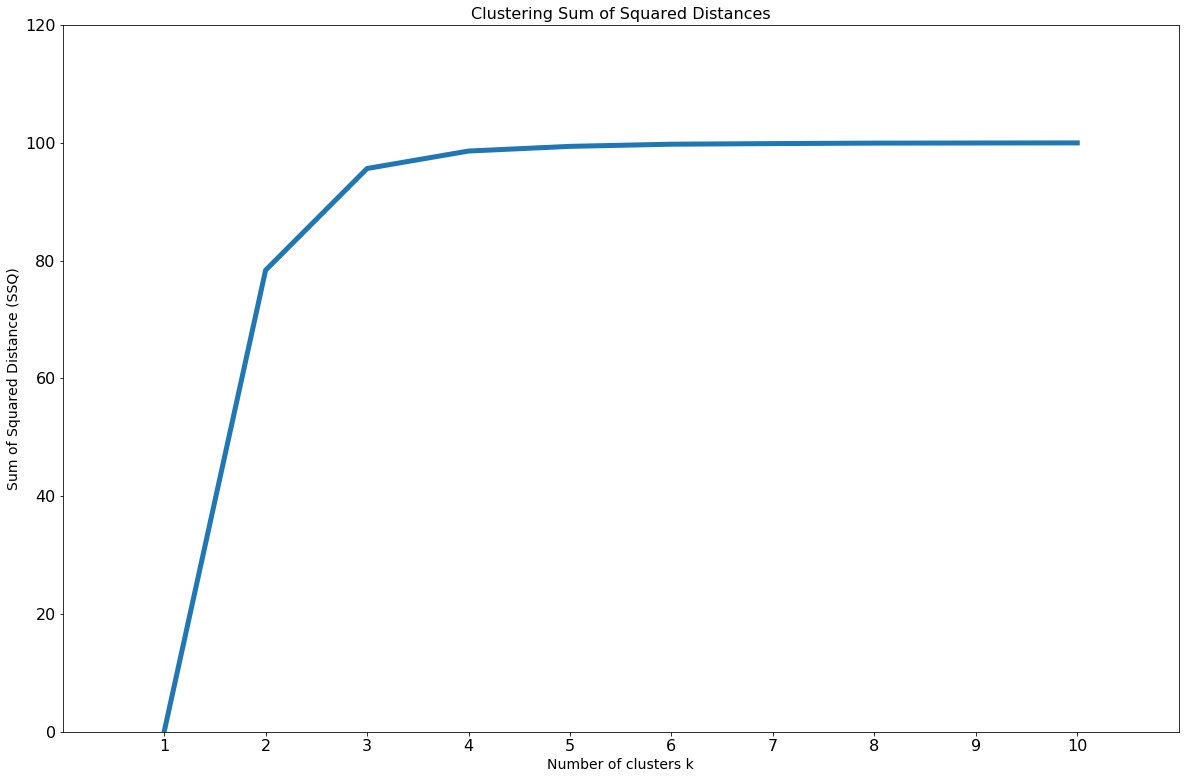

In [176]:

ssqs = ssq_statistics(coins_table,ks=range(1 ,10+1))
plot_ssq_statistics(ssqs)

The optimum clustering value is 4

In [177]:
kmeans = KMeans(n_clusters=4)
kmeans = kmeans.fit(coins_table)
y_kmeans = kmeans.predict(coins_table)

Text(0,0.5,'Market Cap')

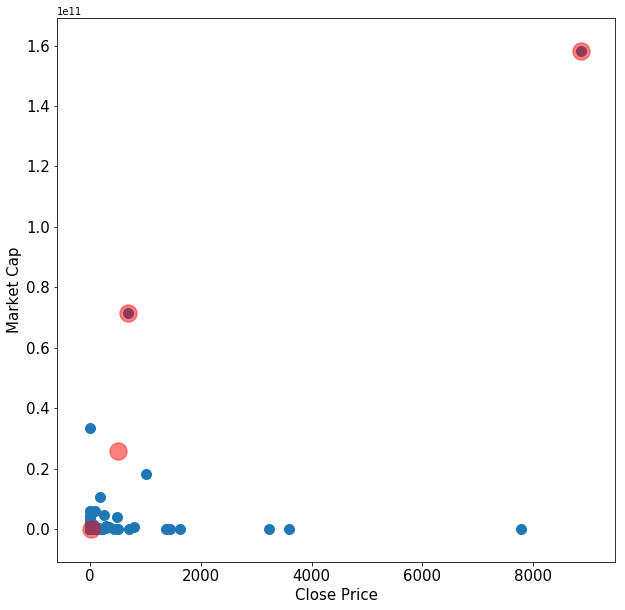

In [178]:
plt.figure(figsize=(10,10))
plt.scatter(coins_table.iloc[:, 0], coins_table.iloc[:, 1],s=100, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='Red', s=300, alpha=0.5);
plt.tick_params(axis='both', which='major', labelsize=15)
plt.tick_params(axis='both', which='minor', labelsize=15)
plt.xlabel('Close Price', fontsize=15)
plt.ylabel('Market Cap', fontsize=15)

### Clutering using volume, market cap and close value

In [179]:
#Cleaning up coins with incorrect data
coins_table = coins_last.drop(columns=['slug', 'symbol', 'name', 'ranknow','date', 'open', 'high', 'close_ratio','spread','low'])
coins_table_1 = coins_table.drop(coins_table.index[800])
coins_table_2 = coins_table_1.drop(coins_table.index[901])
coins_table_3 = coins_table_2.drop(coins_table.index[956])
coins_table = coins_table_3.drop(coins_table.index[814])

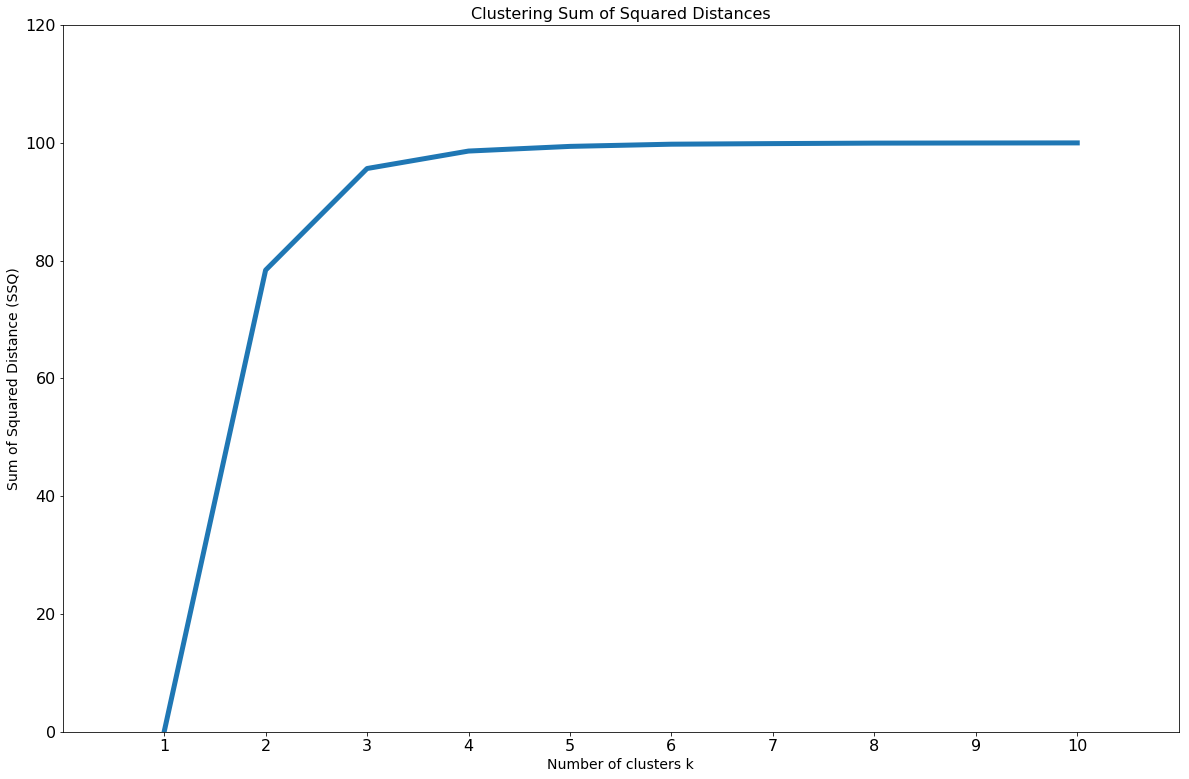

In [180]:

ssqs = ssq_statistics(coins_table,ks=range(1 ,10+1))
plot_ssq_statistics(ssqs)

The optimum clustering value is 4

In [181]:
# Initializing KMeans
kmeans = KMeans(n_clusters=4)
# Fitting with inputs
kmeans = kmeans.fit(coins_table)
# Predicting the clusters
labels = kmeans.predict(coins_table)
# Getting the cluster centers
C = kmeans.cluster_centers_

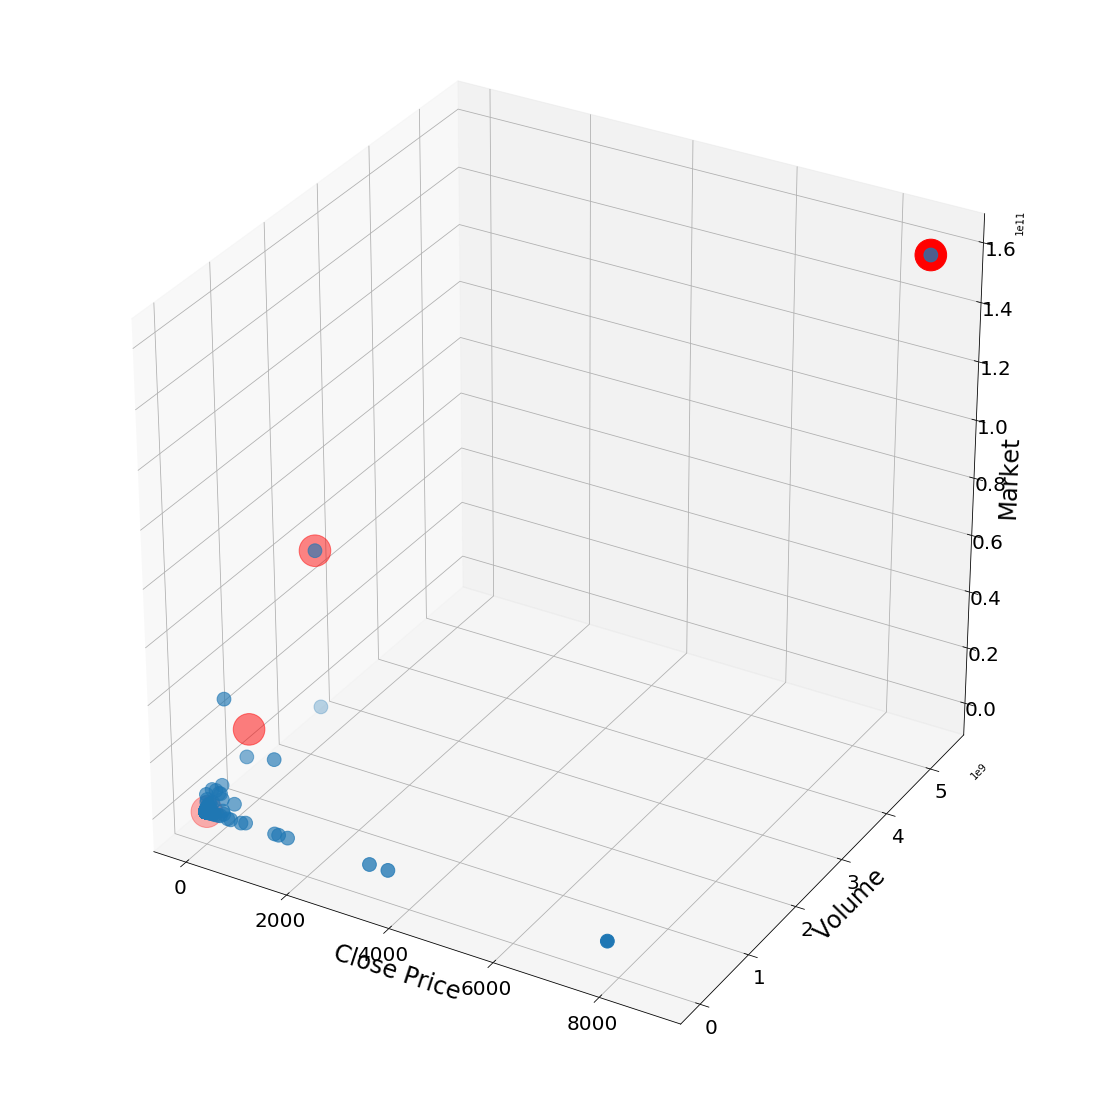

In [182]:
# plotting clustering graph
fig = plt.figure(figsize=(15,15))
ax = Axes3D(fig)
ax.set_xlabel('Close Price', fontsize=24)
ax.set_ylabel('Volume', fontsize=24)
ax.set_zlabel('Market', fontsize=24)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.tick_params(axis='both', which='minor', labelsize=20)
ax.scatter(coins_table.iloc[:, 0], coins_table.iloc[:, 1], coins_table.iloc[:, 2], s=190)
ax.scatter(C[:, 0], C[:, 1], C[:, 2], marker='.', c='Red', s=4000)

# Data percentage for cryptocurrencies

In [183]:
values = data['slug'].value_counts().keys().tolist()[:10]
counts = data['slug'].value_counts().tolist()
values.insert(len(values), 'Others')

In [184]:
limt_count = counts[:10]
limt_count.insert(len(limt_count), sum(counts[10:50]))

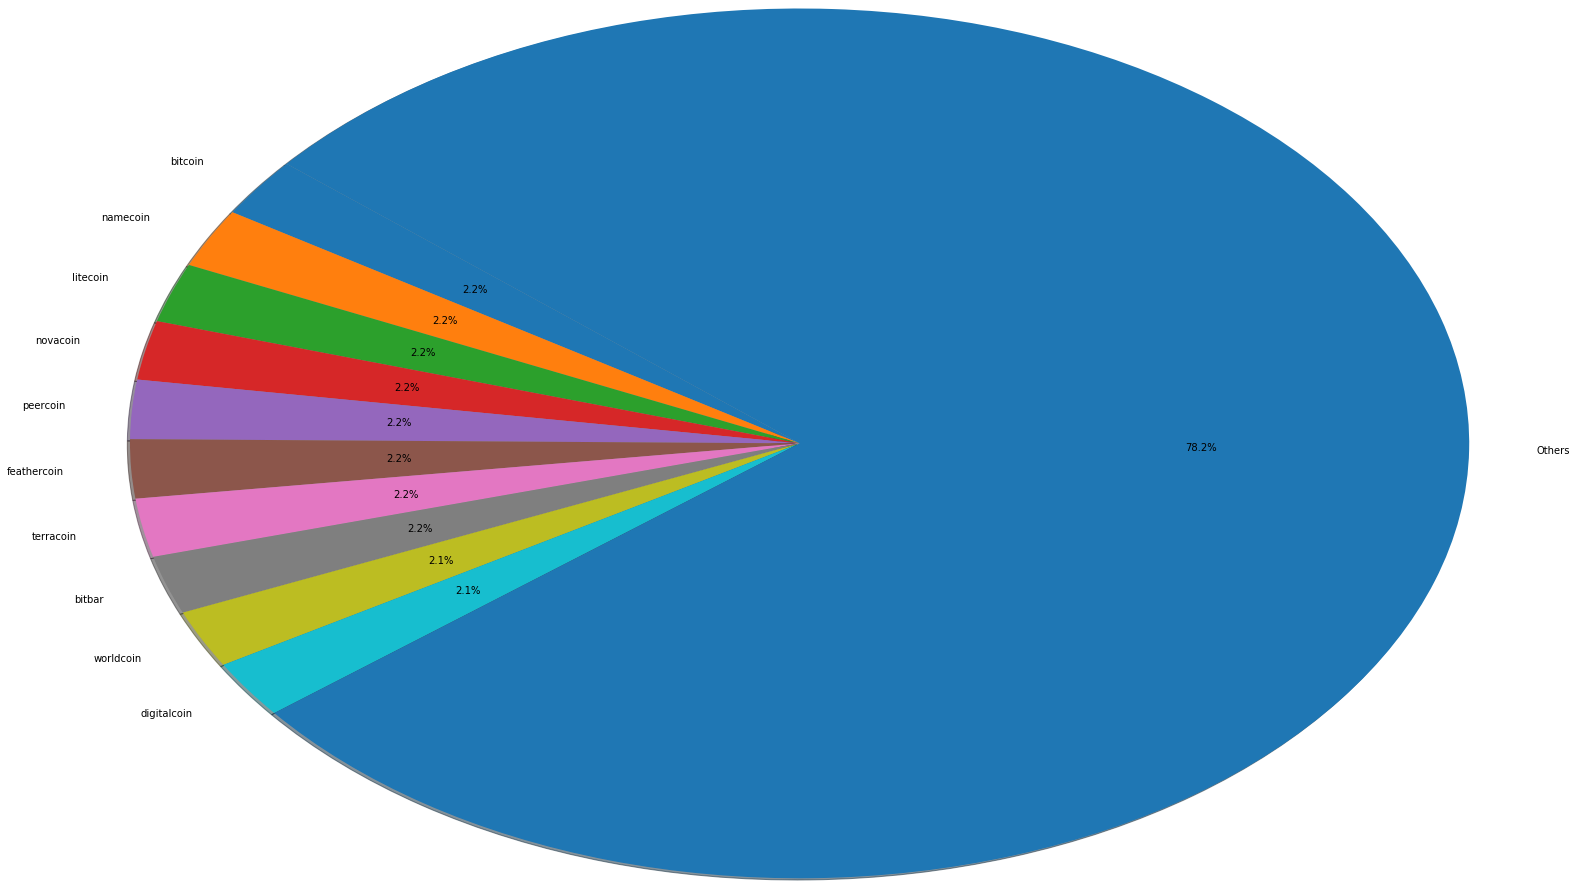

In [185]:
import matplotlib.pyplot as plt
plt.pie(limt_count, labels=values,
        autopct='%1.1f%%', radius=5 ,shadow=True, startangle=140)
plt.rc('font', size=30) 
plt.show()

# LSTM implementation and evaluation

In [186]:
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [187]:
#Convert an array of values into a dataset matrix
def dataset_generate(data, step_size=1):
    dataX, dataY = [], []
    for i in range(len(data)- step_size -1):
        a = data[i:(i+ step_size), 0]
        dataX.append(a)
        dataY.append(data[i + step_size, 0])
    return numpy.array(dataX), numpy.array(dataY)

In [188]:
def predict_perform(coin_name, feature):
    #Fix random seed for reproducibility
    new_data = {}
    for coin_name in data_name_unique[:3]:
        coin = data.loc[data['symbol'] == coin_name]
        coin_close = coin[[feature]].reset_index(drop=True)
        print(coin_name)
        print(coin_close)
        new_data[coin_name] = coin_close
    
    numpy.random.seed(7)
    dataset = new_data[coin_name]
    dataset = dataset.values
    dataset = dataset.astype('float32')
     
    #Normalize the dataset
    scaler = MinMaxScaler(feature_range=(0, 1))
    dataset = scaler.fit_transform(dataset)
    
    # Split into train and test sets
    train_size = int(len(dataset) * 0.98)
    test_size = len(dataset) - train_size
    train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

    # Reshape into X=t and Y=t+1
    step_size = 1
    trainX, trainY = dataset_generate(train, step_size)
    testX, testY = dataset_generate(test, step_size)
    
    
    # Reshape input to be [samples, time steps, features]
    trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
    
    
    model = Sequential()
    model.add(LSTM(100, activation='tanh', input_dim= step_size))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(trainX, trainY, nb_epoch=1, batch_size=1, verbose=2)
    # make predictions

    trainPredict = model.predict(trainX)
    trainLen = len(trainPredict)
    testPredict = []
 
    input = trainY[-1]
    temp = [[input]]
    predX = [temp]
 
    a = model.predict(numpy.array(predX))
    b = a.tolist ()
    predX = [b]
    testPredict.append(b[0])
    
    for i in range(test_size - 3):
        print ('Iteration %d: Done' % i)
        trainX = numpy.concatenate([trainX, [b]])
        trainY = numpy.concatenate ([trainY, b[0]])
        model.fit (trainX, trainY, nb_epoch=1, batch_size=1, verbose=2)
        a = model.predict (numpy.array ([b]))
        b = a.tolist ()
        testPredict.append (b[0])
        print ('Prediction %d:'%i, b)
    
    testPredict = numpy.array(testPredict)
    

    # invert predictions
    trainPredict = scaler.inverse_transform(trainPredict)
    testPredict = scaler.inverse_transform(numpy.array(testPredict))

    print(trainPredict);
    print(testPredict);
    
    trainScore = math.sqrt(mean_squared_error(trainY[:trainLen], trainPredict))
    print('Train Score: %.2f RMSE' % (trainScore))
    testScore = math.sqrt(mean_squared_error(testY, testPredict))
    print('Test Score: %.2f RMSE' % (testScore))
    

    testPredict = numpy.pad(testPredict, (len(trainPredict),0), 'constant', constant_values=(np.nan, 0))
    # plot baseline and predictions
    plt.figure(figsize=(50,30))
    plt.tick_params(axis='both', which='major', labelsize=40)
    plt.tick_params(axis='both', which='minor', labelsize=40)

    a = plt.plot(scaler.inverse_transform(dataset), label='dataset', linewidth=7.0)
    b = plt.plot(trainPredict, label='Trained Predicton', linewidth=7.0)
    c = plt.plot(testPredict, label='Test Prediction', linewidth=7.0)
    plt.legend(loc=2, prop={'size': 40}, labels=["dataset",'Trained Predicton','Test Prediction'])
    plt.ylabel('Close Price', fontsize=50)
    plt.xlabel('Time Series Data from 2013 to 2018', fontsize=50)
    plt.show()

BTC
            market
0     1.500520e+09
1     1.491160e+09
2     1.597780e+09
3     1.542820e+09
4     1.292190e+09
5     1.180070e+09
6     1.089890e+09
7     1.254760e+09
8     1.289470e+09
9     1.248470e+09
10    1.219450e+09
11    1.259980e+09
12    1.255970e+09
13    1.311050e+09
14    1.288630e+09
15    1.279980e+09
16    1.315720e+09
17    1.242760e+09
18    1.274620e+09
19    1.319590e+09
20    1.379140e+09
21    1.376370e+09
22    1.368910e+09
23    1.363940e+09
24    1.374130e+09
25    1.384780e+09
26    1.413300e+09
27    1.489950e+09
28    1.478030e+09
29    1.495520e+09
...            ...
1763  1.736820e+11
1764  1.654070e+11
1765  1.632830e+11
1766  1.755360e+11
1767  1.805100e+11
1768  1.754270e+11
1769  1.854560e+11
1770  1.875810e+11
1771  1.942890e+11
1772  1.949030e+11
1773  1.943780e+11
1774  1.826310e+11
1775  1.682410e+11
1776  1.591850e+11
1777  1.581190e+11
1778  1.497160e+11
1779  1.624210e+11
1780  1.551680e+11
1781  1.558910e+11
1782  1.402750e+11
1783  1.

C:\Users\raghu\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
C:\Users\raghu\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(100, activation="tanh", input_shape=(None, 1))`
C:\Users\raghu\Anaconda3\lib\site-packages\keras\models.py:942: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Epoch 1/1
 - 6s - loss: 0.0039
Iteration 0: Done
Epoch 1/1
 - 4s - loss: 2.2998e-04
Prediction 0: [[0.49142134189605713]]
Iteration 1: Done
Epoch 1/1
 - 4s - loss: 2.3072e-04
Prediction 1: [[0.48377901315689087]]
Iteration 2: Done
Epoch 1/1
 - 4s - loss: 2.3121e-04
Prediction 2: [[0.45882588624954224]]
Iteration 3: Done
Epoch 1/1
 - 4s - loss: 2.2495e-04
Prediction 3: [[0.4535149335861206]]
Iteration 4: Done
Epoch 1/1
 - 4s - loss: 2.2656e-04
Prediction 4: [[0.46456101536750793]]
Iteration 5: Done
Epoch 1/1
 - 4s - loss: 1.7329e-04
Prediction 5: [[0.5469232797622681]]
Iteration 6: Done
Epoch 1/1
 - 4s - loss: 2.3198e-04
Prediction 6: [[0.5246351957321167]]
Iteration 7: Done
Epoch 1/1
 - 4s - loss: 2.0983e-04
Prediction 7: [[0.4981178939342499]]
Iteration 8: Done
Epoch 1/1
 - 4s - loss: 2.2491e-04
Prediction 8: [[0.4662698209285736]]
Iteration 9: Done
Epoch 1/1
 - 4s - loss: 1.9339e-04
Prediction 9: [[0.5041972398757935]]
Iteration 10: Done
Epoch 1/1
 - 4s - loss: 1.8032e-04
Prediction 

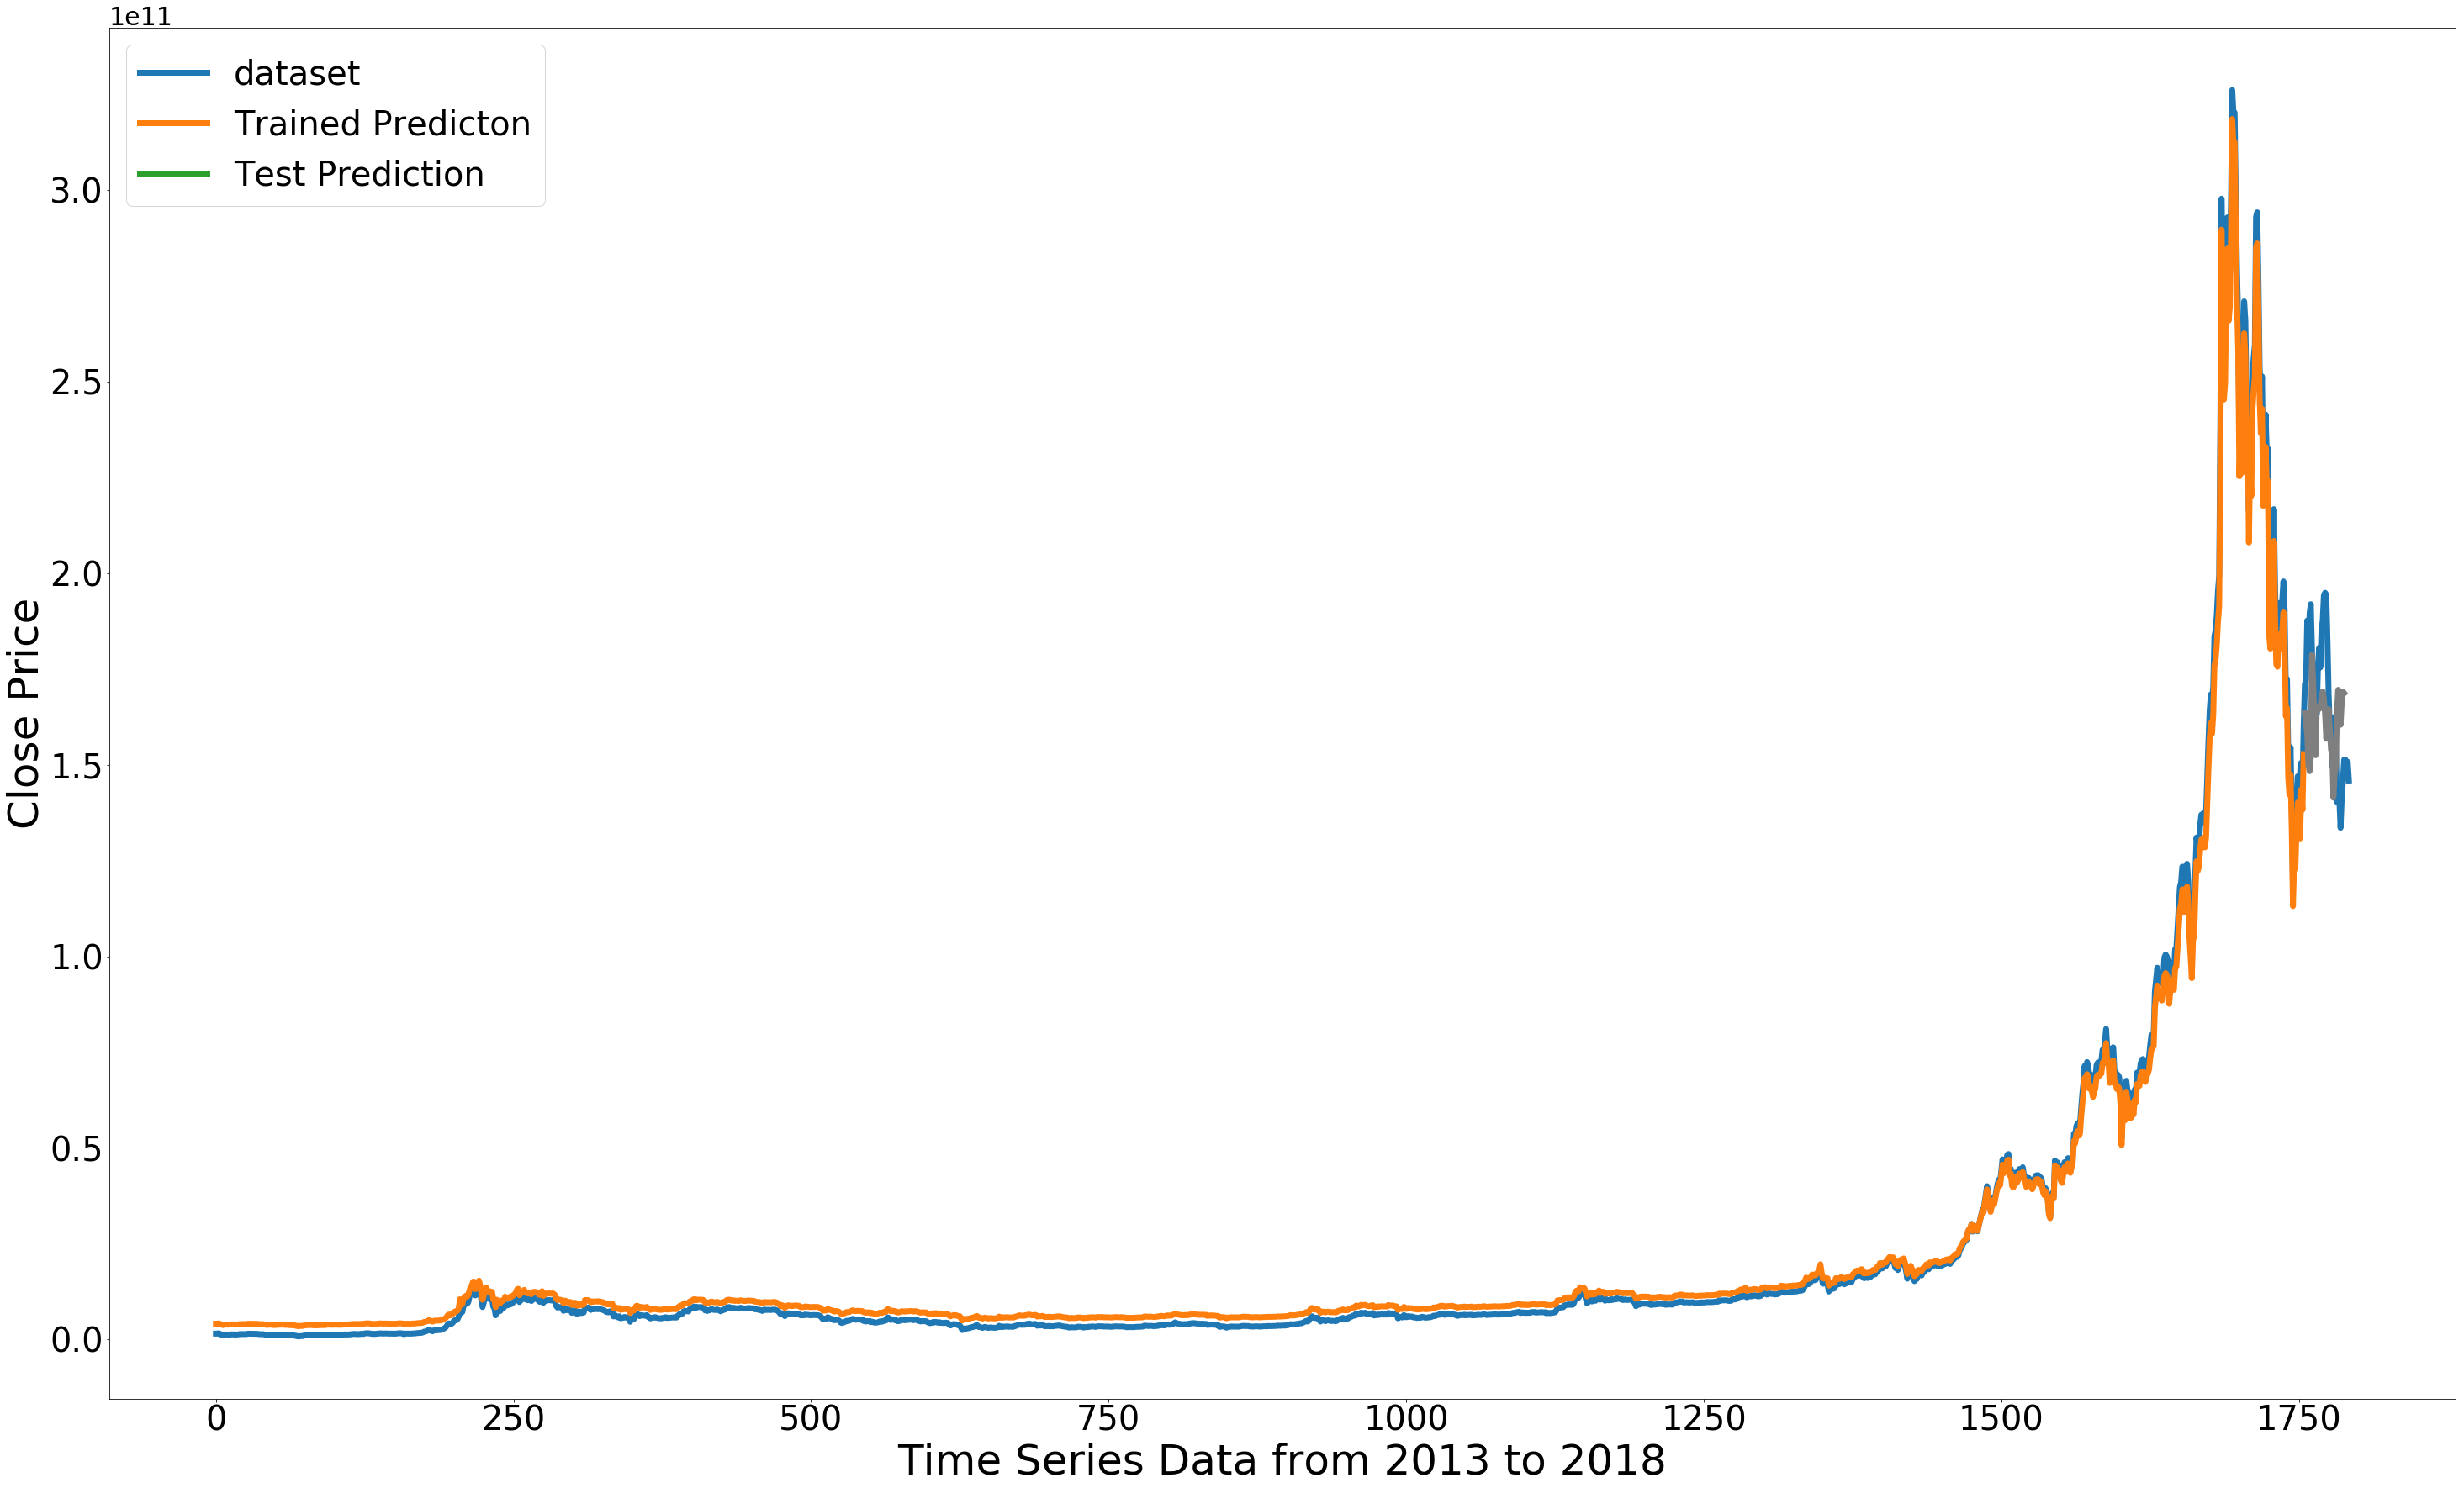

BTC
         close
0       134.21
1       144.54
2       139.00
3       116.99
4       105.21
5        97.75
6       112.50
7       115.91
8       112.30
9       111.50
10      113.57
11      112.67
12      117.20
13      115.24
14      115.00
15      117.98
16      111.50
17      114.22
18      118.76
19      123.02
20      123.50
21      121.99
22      122.00
23      122.88
24      123.89
25      126.70
26      133.20
27      131.98
28      133.48
29      129.75
...        ...
1763   9813.07
1764   9664.73
1765  10366.70
1766  10725.60
1767  10397.90
1768  10951.00
1769  11086.40
1770  11489.70
1771  11512.60
1772  11573.30
1773  10779.90
1774   9965.57
1775   9395.01
1776   9337.55
1777   8866.00
1778   9578.63
1779   9205.12
1780   9194.85
1781   8269.81
1782   8300.86
1783   8338.35
1784   7916.88
1785   8223.68
1786   8630.65
1787   8913.47
1788   8929.28
1789   8728.47
1790   8879.62
1791   8668.12
1792   8495.78

[1793 rows x 1 columns]
Epoch 1/1
 - 5s - loss: 0.0037
Iteration 

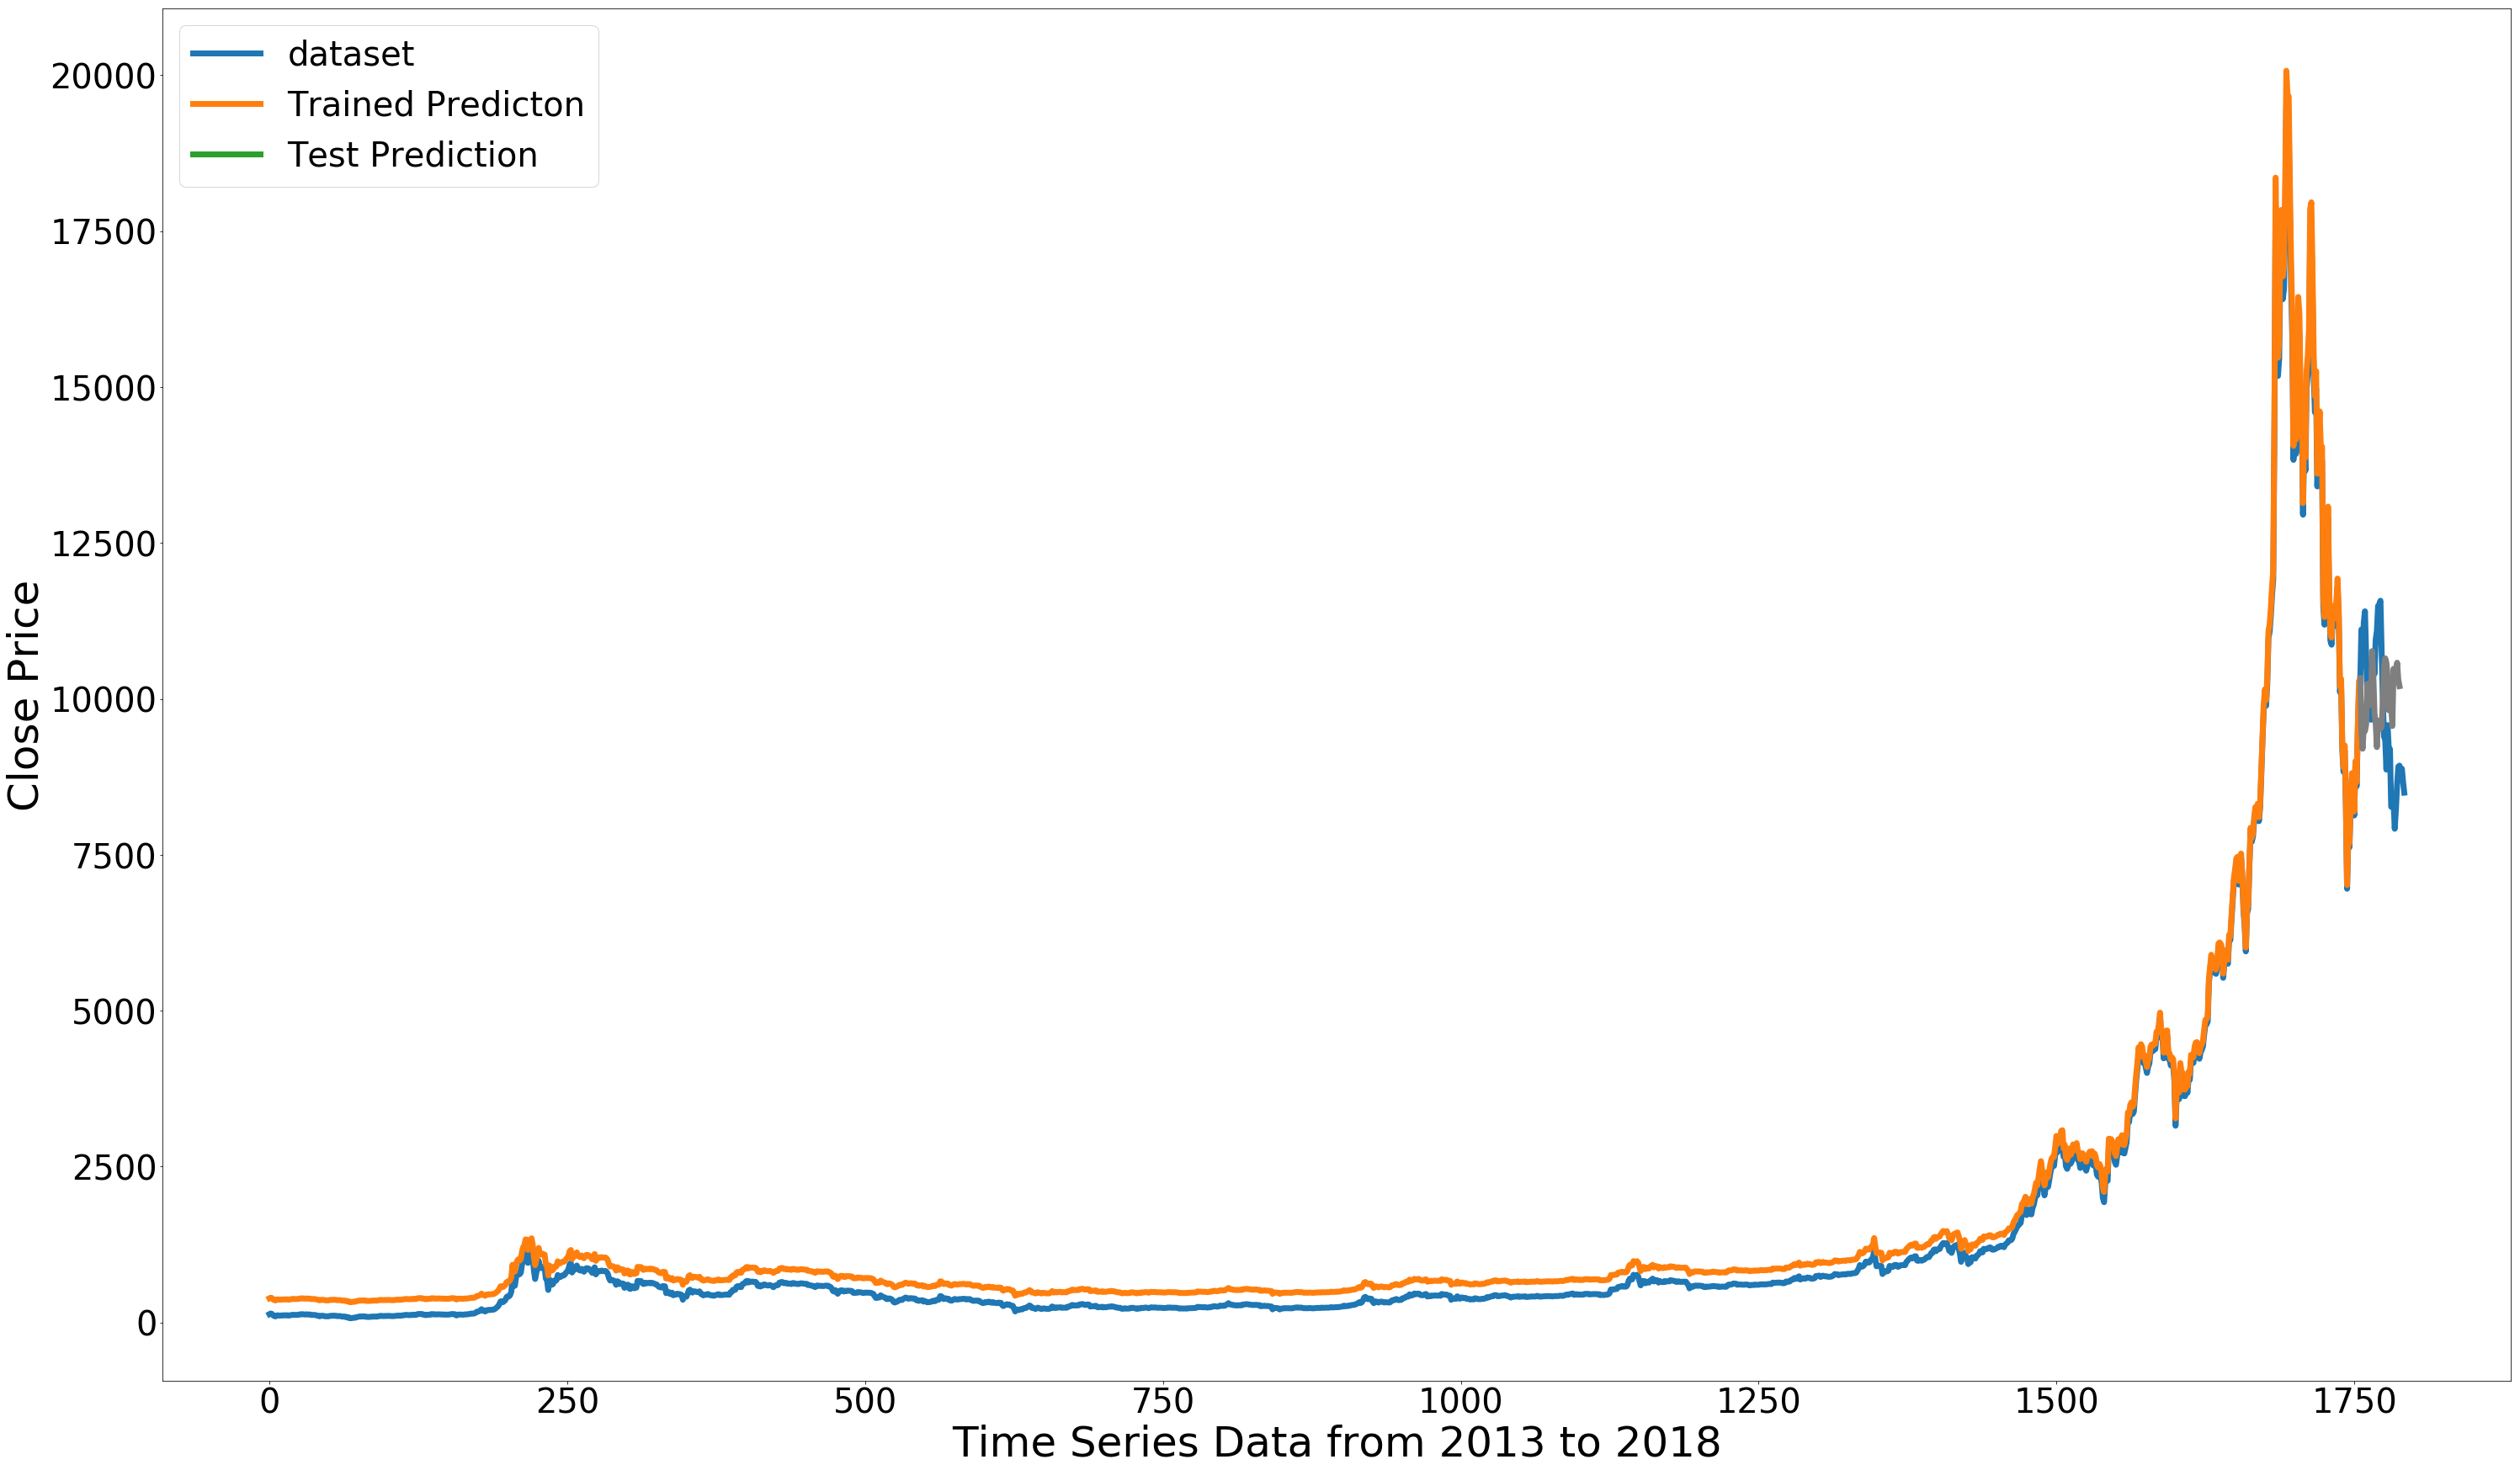

In [189]:
data_name_unique = ['BTC']
for coin_name in data_name_unique:
    predict_perform(coin_name, 'market')
    predict_perform(coin_name, 'close')

# LSTM Prediction for future values

In [190]:
direc = "./prediction_files/"
directory = os.path.dirname(direc)
if not os.path.exists(directory):
    os.makedirs(directory)

In [191]:
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [192]:
def predict(days, coin_name, feature):
    new_data = {}
    coin = data.loc[data['symbol'] == coin_name]
    coin_close = coin[[feature]].reset_index(drop=True)
    print(coin_name)
    print(coin_close)
    new_data[coin_name] = coin_close  
    
    #Fix random seed for reproducibility
    numpy.random.seed(7)
    dataset = new_data[coin_name]
    dataset = dataset.values
    dataset = dataset.astype('float32')
    
    #Normalize the dataset
    scaler = MinMaxScaler(feature_range=(0, 1))
    dataset = scaler.fit_transform(dataset)
    # split into train and test sets
    # Split into train and test sets
    train_size = len(dataset)
    train = dataset[0:train_size,:]

    # Reshape into X=t and Y=t+1
    step_size = 1
    trainX, trainY = dataset_generate(train, step_size)
        
    # Reshape input to be [samples, time steps, features]
    trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
        
    model = Sequential()
    model.add(LSTM(100, activation='tanh', input_dim= step_size))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(trainX, trainY, nb_epoch=1, batch_size=1, verbose=2)
    # make predictions

    trainPredict = model.predict(trainX)
    trainLen = len(trainPredict)
    testPredict = []
 
    input = trainY[-1]
    temp = [[input]]
    predX = [temp]
 
    a = model.predict(numpy.array(predX))
    b = a.tolist ()
    predX = [b]
    testPredict.append([input])
    testPredict.append(b[0])
    
    for i in range(days-1):
        print ('Iteration %d: Done' % i)
        trainX = numpy.concatenate([trainX, [b]])
        trainY = numpy.concatenate ([trainY, b[0]])
        model.fit (trainX, trainY, nb_epoch=1, batch_size=1, verbose=2)
        a = model.predict (numpy.array ([b]))
        b = a.tolist ()
        testPredict.append (b[0])
        print ('Prediction %d:'%i, b)
    
    testPredict = numpy.array(testPredict)
    filename = direc+"coin_"+coin_name+"_"+feature+".txt";
    
    # invert predictions
    trainPredict = scaler.inverse_transform(trainPredict)
    testPredict = scaler.inverse_transform(numpy.array(testPredict))
    
    testPredict.tofile(filename, sep=',', format="%s")

    testPredict = numpy.pad(testPredict, (len(trainPredict),0), 'constant', constant_values=(np.nan, 0))
    
    # plot baseline and predictions
    plt.figure(figsize=(50,30))
    plt.tick_params(axis='both', which='major', labelsize=40)
    plt.tick_params(axis='both', which='minor', labelsize=40)

    a = plt.plot(scaler.inverse_transform(dataset), label='dataset', linewidth=7.0)
    b = plt.plot(trainPredict, label='Trained Predicton', linewidth=7.0)
    c = plt.plot(testPredict, label='Test Prediction', linewidth=7.0)
    plt.legend(loc=2, prop={'size': 40}, labels=["dataset",'Trained Predicton','Test Prediction'])
    plt.ylabel('Close Price', fontsize=50)
    plt.xlabel('Time Series Data from 2013 to 2018', fontsize=50)
    plt.show()

BTC
         close
0       134.21
1       144.54
2       139.00
3       116.99
4       105.21
5        97.75
6       112.50
7       115.91
8       112.30
9       111.50
10      113.57
11      112.67
12      117.20
13      115.24
14      115.00
15      117.98
16      111.50
17      114.22
18      118.76
19      123.02
20      123.50
21      121.99
22      122.00
23      122.88
24      123.89
25      126.70
26      133.20
27      131.98
28      133.48
29      129.75
...        ...
1763   9813.07
1764   9664.73
1765  10366.70
1766  10725.60
1767  10397.90
1768  10951.00
1769  11086.40
1770  11489.70
1771  11512.60
1772  11573.30
1773  10779.90
1774   9965.57
1775   9395.01
1776   9337.55
1777   8866.00
1778   9578.63
1779   9205.12
1780   9194.85
1781   8269.81
1782   8300.86
1783   8338.35
1784   7916.88
1785   8223.68
1786   8630.65
1787   8913.47
1788   8929.28
1789   8728.47
1790   8879.62
1791   8668.12
1792   8495.78

[1793 rows x 1 columns]


C:\Users\raghu\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
C:\Users\raghu\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(100, activation="tanh", input_shape=(None, 1))`
C:\Users\raghu\Anaconda3\lib\site-packages\keras\models.py:942: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Epoch 1/1
 - 5s - loss: 0.0043
Iteration 0: Done
Epoch 1/1
 - 4s - loss: 2.5208e-04
Prediction 0: [[0.43898865580558777]]
Iteration 1: Done
Epoch 1/1
 - 4s - loss: 2.5333e-04
Prediction 1: [[0.4778093993663788]]
Iteration 2: Done
Epoch 1/1
 - 4s - loss: 2.3820e-04
Prediction 2: [[0.4794798493385315]]
Iteration 3: Done
Epoch 1/1
 - 4s - loss: 2.3056e-04
Prediction 3: [[0.5463136434555054]]
Iteration 4: Done
Epoch 1/1
 - 5s - loss: 2.3104e-04
Prediction 4: [[0.5569125413894653]]
Iteration 5: Done
Epoch 1/1
 - 4s - loss: 2.1135e-04
Prediction 5: [[0.5443605184555054]]
Iteration 6: Done
Epoch 1/1
 - 4s - loss: 2.3295e-04
Prediction 6: [[0.5428702235221863]]
Iteration 7: Done
Epoch 1/1
 - 4s - loss: 2.0607e-04
Prediction 7: [[0.5317692160606384]]
Iteration 8: Done
Epoch 1/1
 - 4s - loss: 2.1943e-04
Prediction 8: [[0.5265408754348755]]


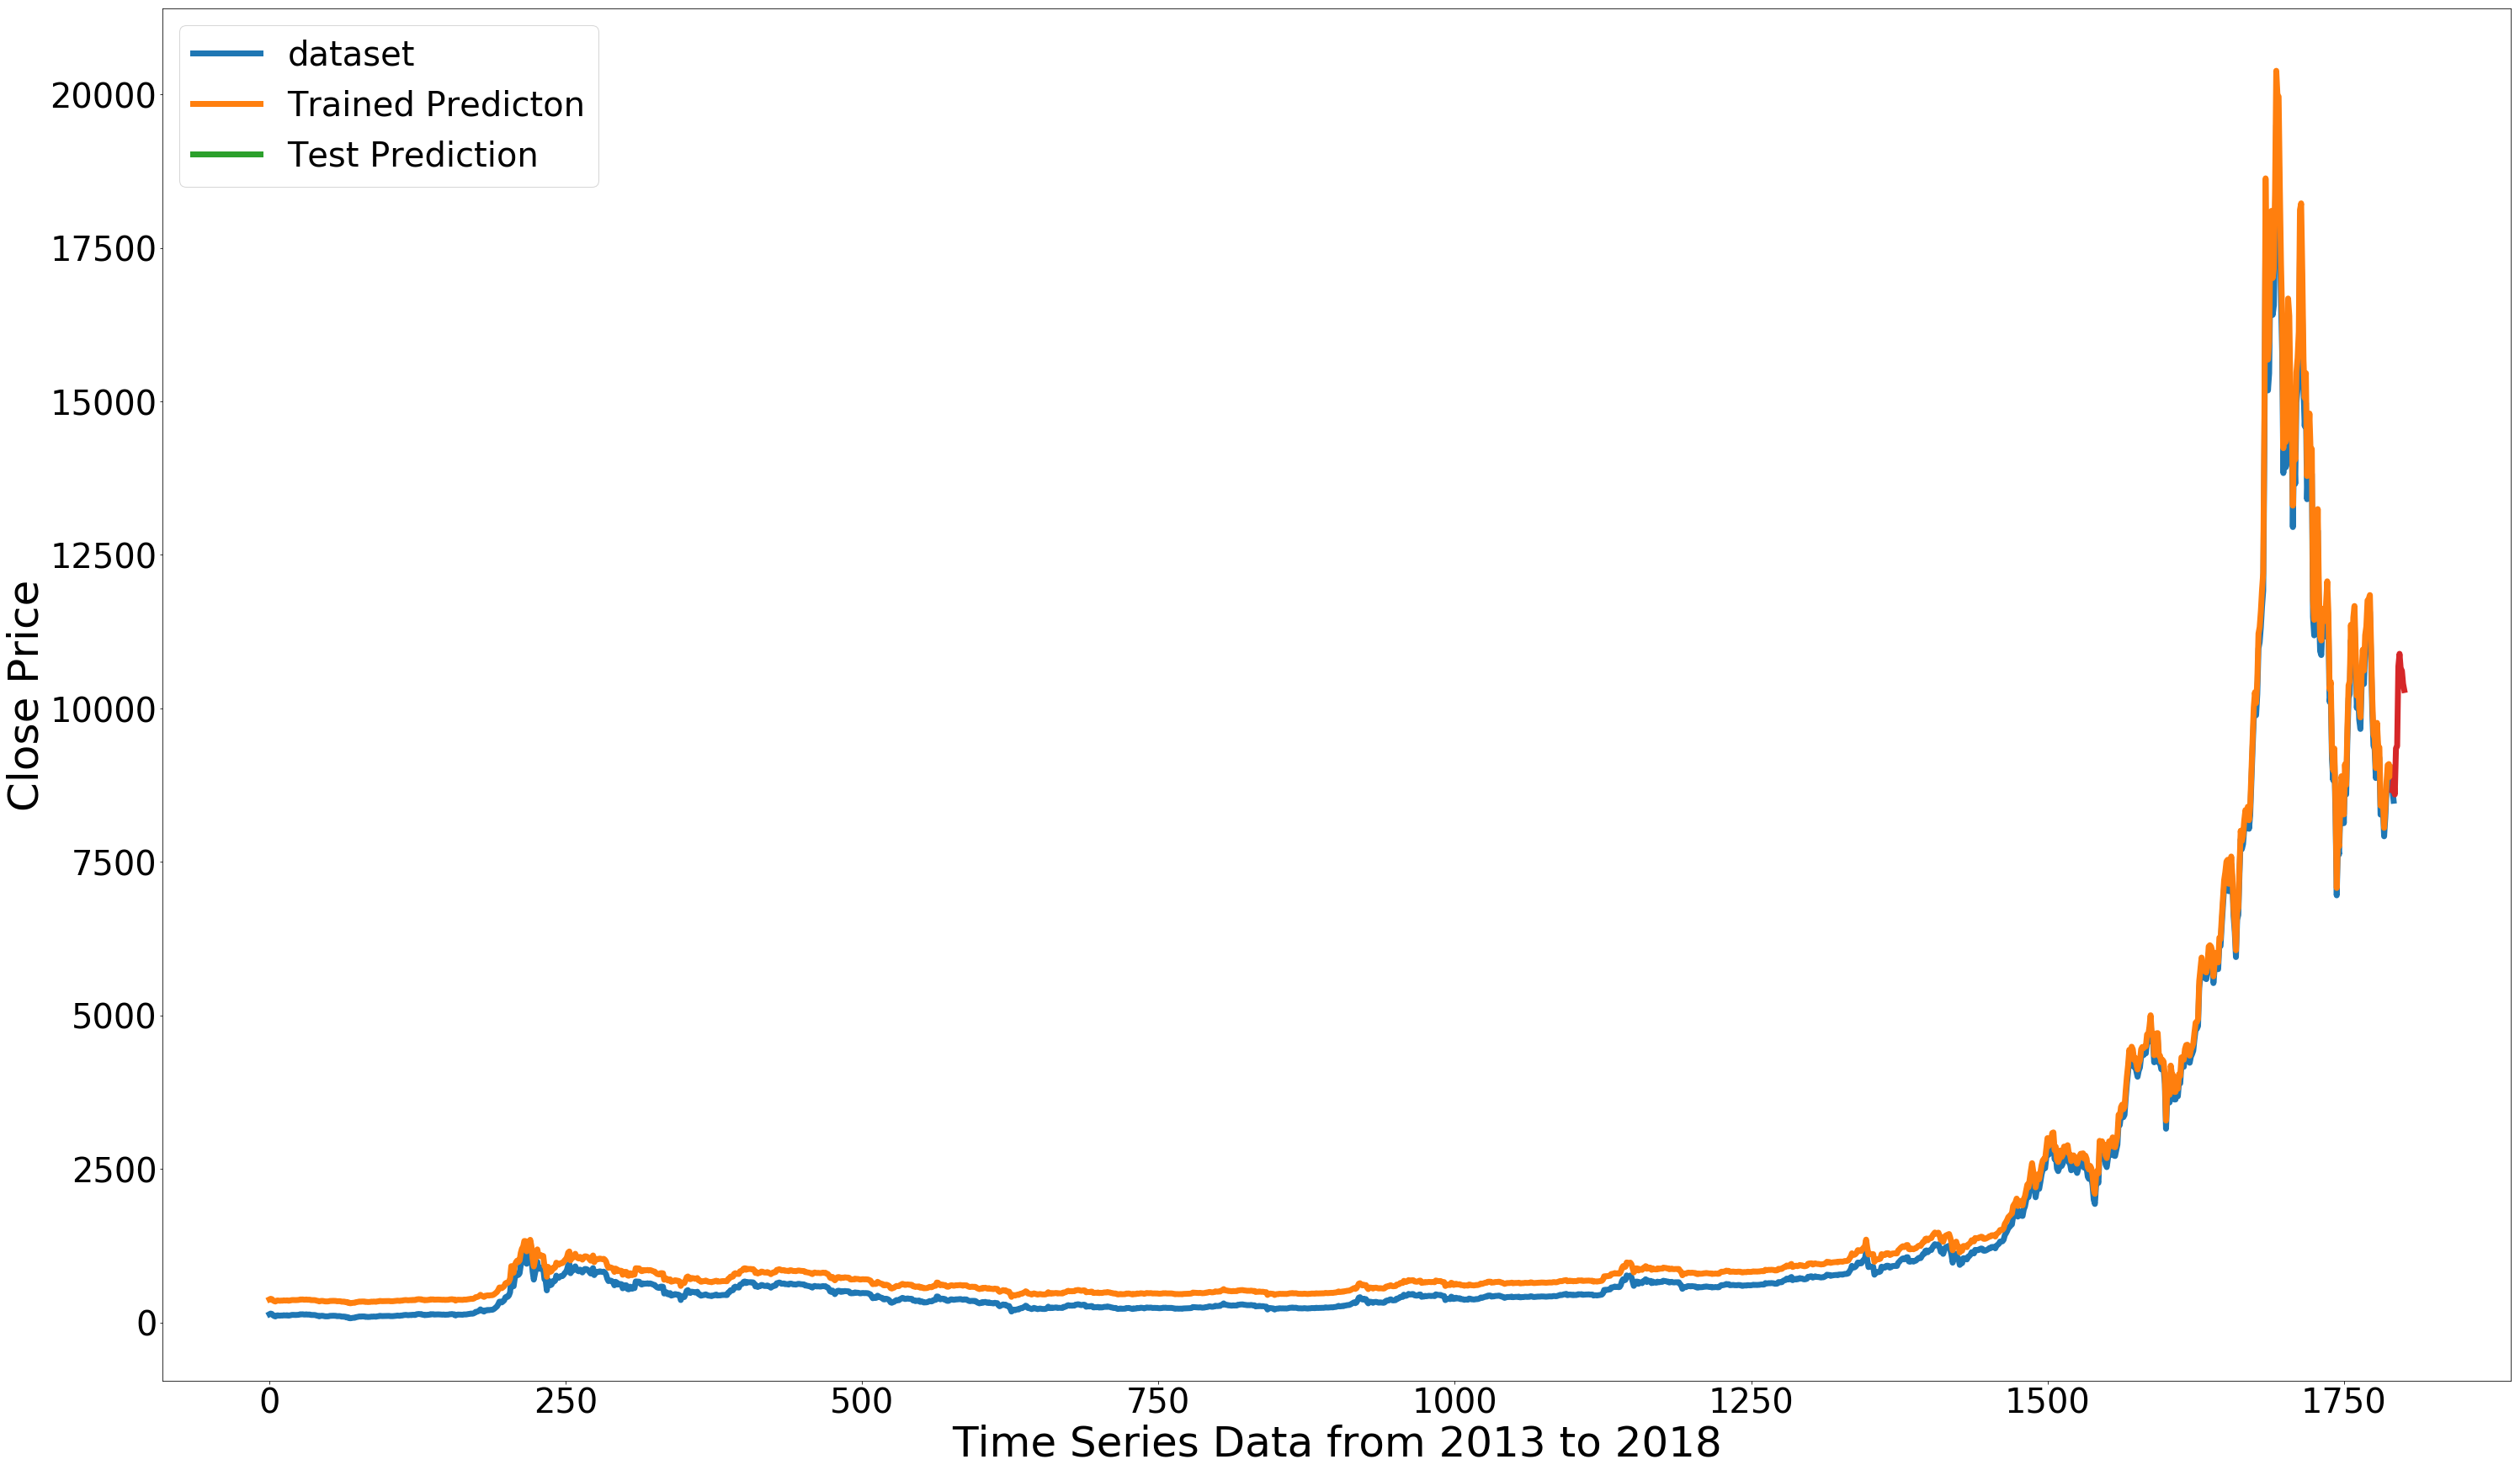

BTC
            market
0     1.500520e+09
1     1.491160e+09
2     1.597780e+09
3     1.542820e+09
4     1.292190e+09
5     1.180070e+09
6     1.089890e+09
7     1.254760e+09
8     1.289470e+09
9     1.248470e+09
10    1.219450e+09
11    1.259980e+09
12    1.255970e+09
13    1.311050e+09
14    1.288630e+09
15    1.279980e+09
16    1.315720e+09
17    1.242760e+09
18    1.274620e+09
19    1.319590e+09
20    1.379140e+09
21    1.376370e+09
22    1.368910e+09
23    1.363940e+09
24    1.374130e+09
25    1.384780e+09
26    1.413300e+09
27    1.489950e+09
28    1.478030e+09
29    1.495520e+09
...            ...
1763  1.736820e+11
1764  1.654070e+11
1765  1.632830e+11
1766  1.755360e+11
1767  1.805100e+11
1768  1.754270e+11
1769  1.854560e+11
1770  1.875810e+11
1771  1.942890e+11
1772  1.949030e+11
1773  1.943780e+11
1774  1.826310e+11
1775  1.682410e+11
1776  1.591850e+11
1777  1.581190e+11
1778  1.497160e+11
1779  1.624210e+11
1780  1.551680e+11
1781  1.558910e+11
1782  1.402750e+11
1783  1.

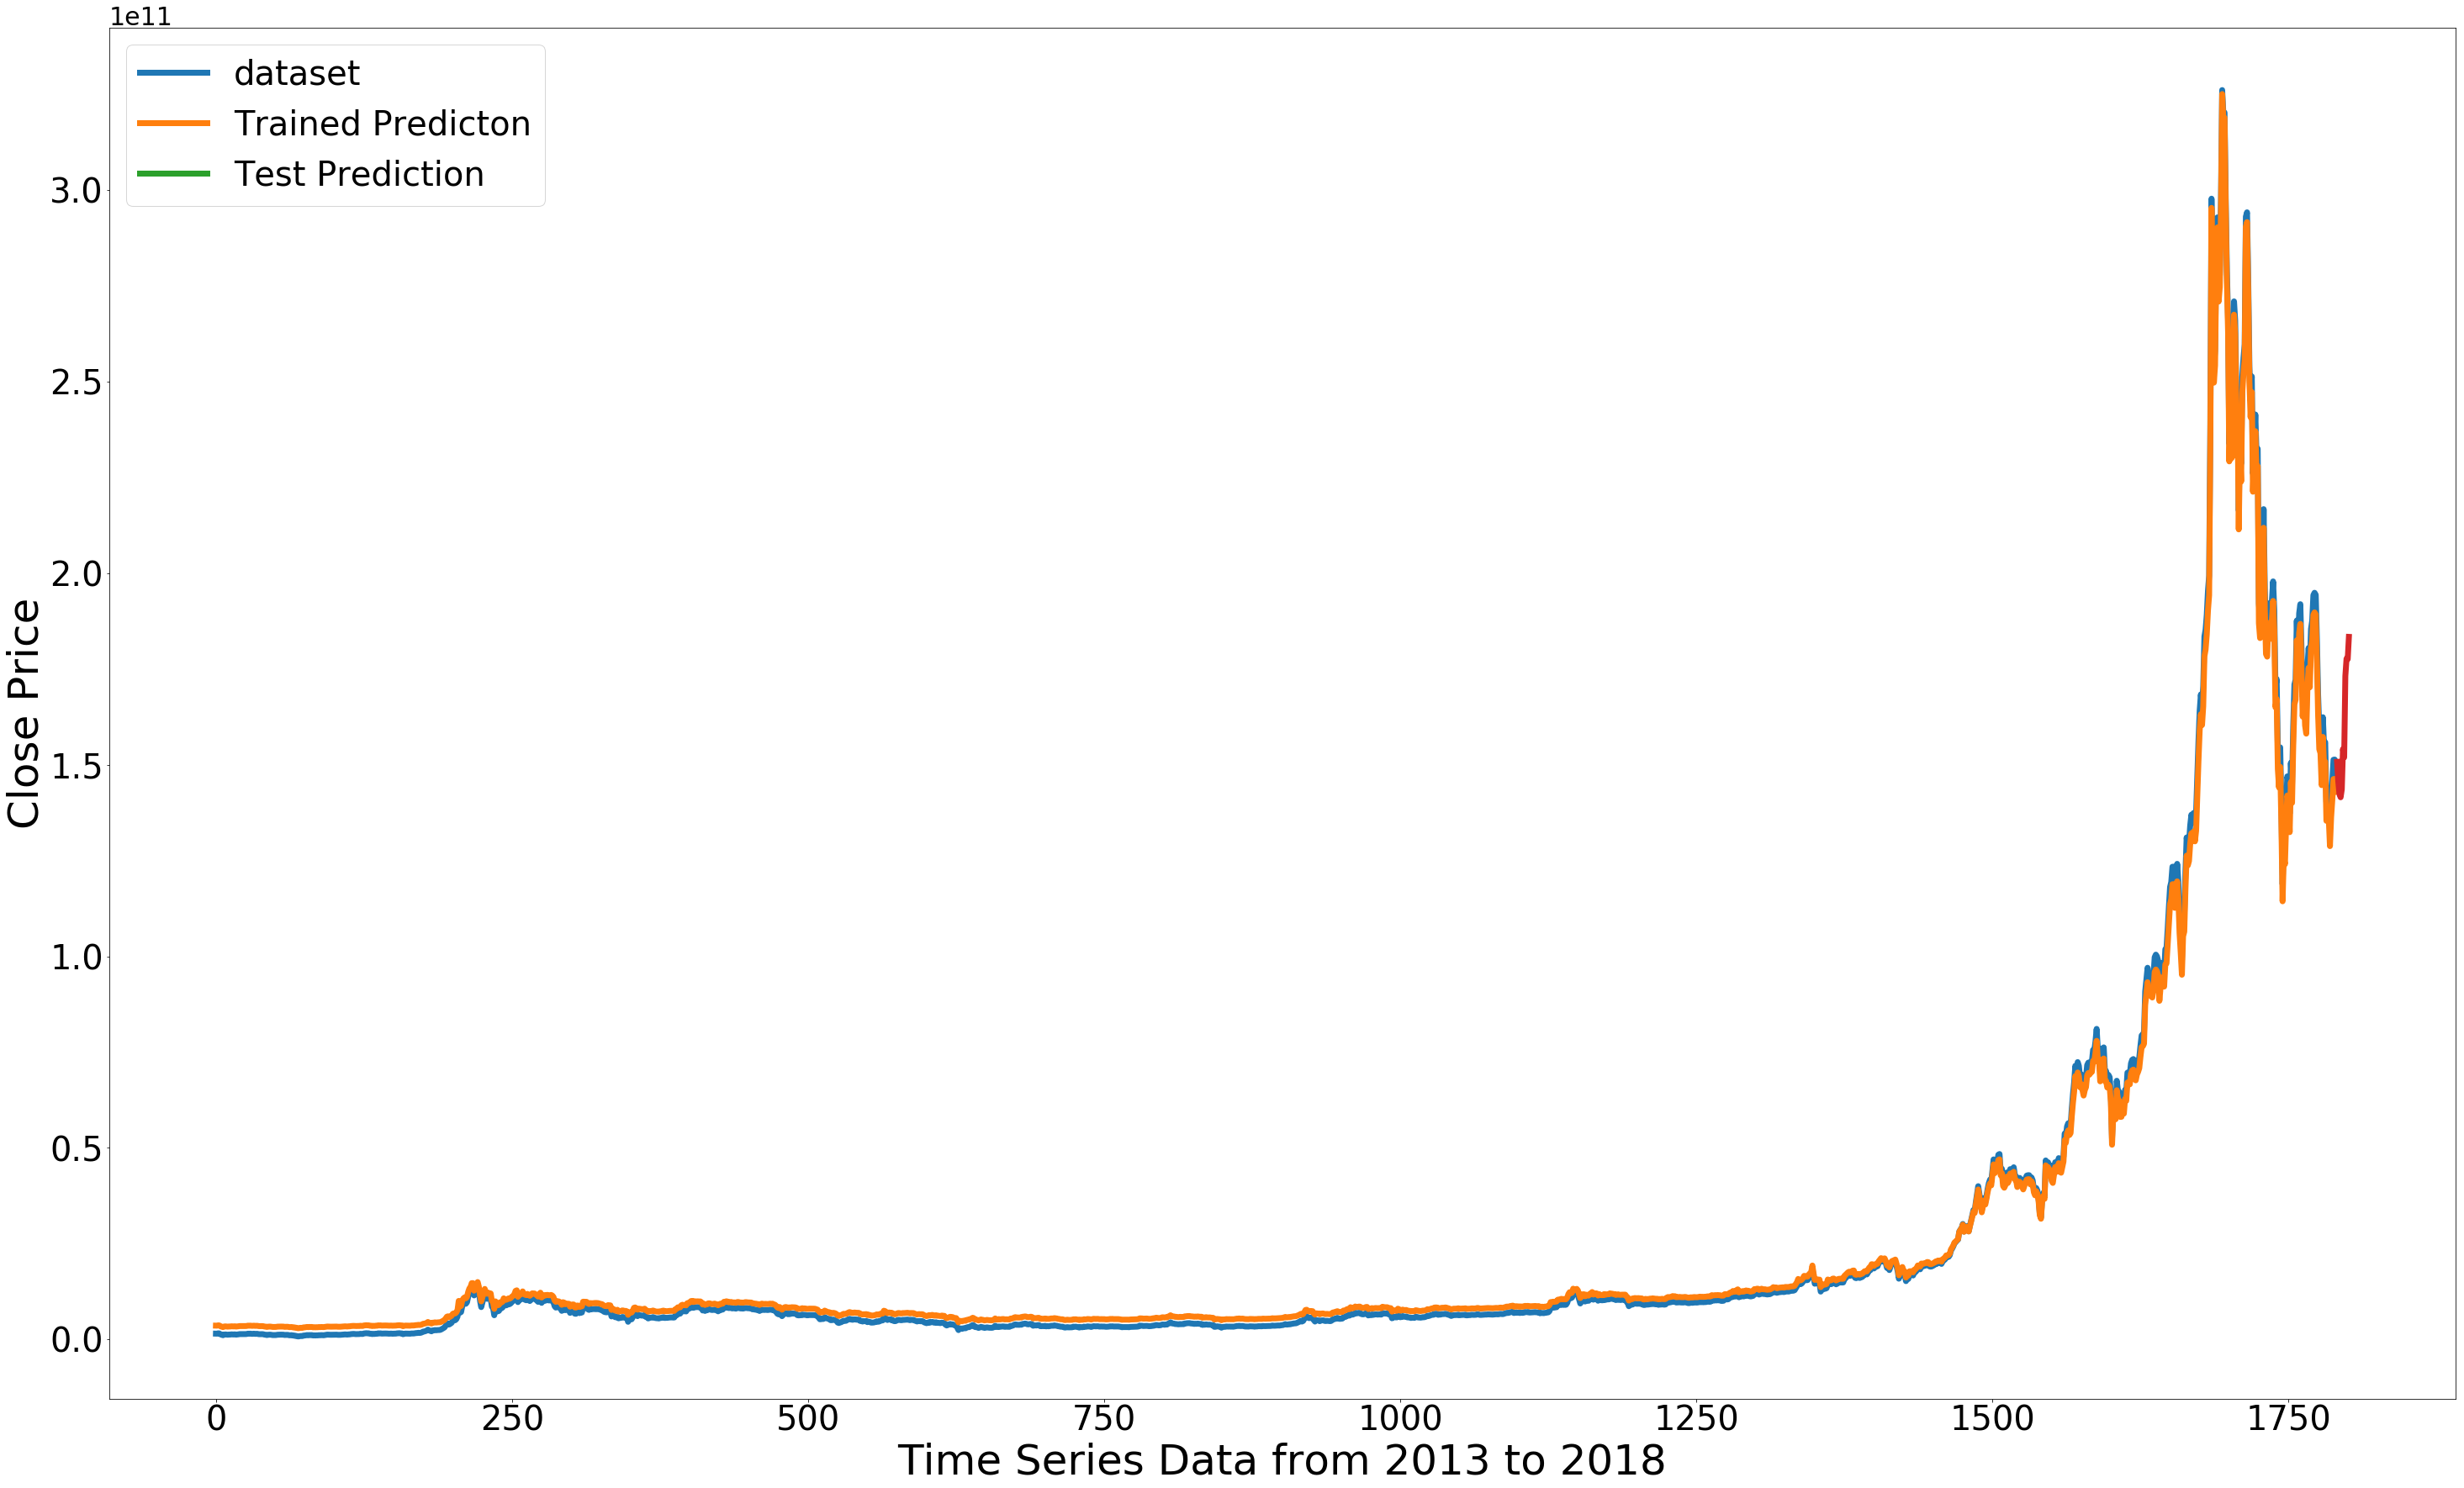

In [193]:
data_name_unique = ['BTC']
for coin_name in data_name_unique:
    predict(10, coin_name, 'close')
    predict(10, coin_name, 'market')